In [ ]:
from google.colab import drive 
import os
drive.mount('/content/drive')
path = "/content/drive/My Drive/Bookpred/Assignment 2"
%cd {path}
!ls

Mounted at /content/drive
/content/drive/My Drive/Bookpred/Assignment 2
 8.prep_IMDB.ipynb
'Assignment 2 Track.gdoc'
 bert
 best_model
 book_rating_test.csv
 book_rating_train.csv
 book_text_features_countvec
 book_text_features_doc2vec
 book_text_features_tfidf
 COMP30027_Project2_spec_2023S1.pdf
'Copy of model.png'
 English
'English (1)'
'Feature engineering.ipynb'
 full_dataset
 history.pkl
 history_v.pkl
 lgbm_class_weight.joblib
 lgbm_normal.joblib
 lgbm_oversampling.joblib
 matrix.npz
 Model.ipynb
 model.png
 multilingual_best
 multilingual_epochs
 output.csv
 Oversampling
 Oversampling_real
 partition
 random_forest_doc.joblib
 random_forest.joblib
 random_forest_num.joblib
 rf_cw.joblib
 rf_normal.joblib
 rf_smote.joblib
 small_bert
 smallbert_class_weight.png
 smallbert_focal.png
 smallbert_normal.png
 smallbert_oversampling_minority.png
 Test
 test_focal.npy
 text_features_description.ipynb
 train_ind.pkl
 Validation
 val_ind.pkl
 val_output_smallbert_class_weights.pkl
 val_o

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import scipy
from matplotlib import pyplot as plt
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.decomposition import PCA

This notebook partially adopts certain code blocks from ChatGPT for visualization, model saving, loading, ... However, the core ideads are original

only run the LGBM part for grid-search cross validaiton with no other purposes, can go straight to LGBM part to see the tuned parameters

# Data preparation

## Data wrangling

In [ ]:
# Norm + impute

train_df_orig = pd.read_csv("book_rating_train.csv")
test_df_orig = pd.read_csv("book_rating_test.csv")

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
cat_attribs = ['Publisher', 'PublishDay']
num_attribs = ["pagesNumber", "PublishYear"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attribs)
    ], remainder = 'drop')

num_df = full_pipeline.fit_transform(train_df_orig)
print(num_df.shape)

num_df_test = full_pipeline.transform(test_df_orig)
print(num_df_test.shape)

(23063, 2)
(5766, 2)


train_df_orig[train_df_orig['Publisher'] == 'Penguin Classics']

## Vectorizer

In [ ]:
# method  = ['countvec', 'tfidf', 'doc2vec]
def convert_npz(method):
  test_name = scipy.sparse.load_npz(f'./book_text_features_{method}/test_name_vec.npz')
  test_authors = scipy.sparse.load_npz(f'./book_text_features_{method}/test_authors_vec.npz')
  test_desc = scipy.sparse.load_npz(f'./book_text_features_{method}/test_desc_vec.npz')

  train_name = scipy.sparse.load_npz(f'./book_text_features_{method}/train_name_vec.npz')
  train_authors = scipy.sparse.load_npz(f'./book_text_features_{method}/train_authors_vec.npz')
  train_desc = scipy.sparse.load_npz(f'./book_text_features_{method}/train_desc_vec.npz')

  return test_name, test_authors, test_desc, train_name, train_authors, train_desc

test_name, test_authors, test_desc, train_name, train_authors, train_desc = convert_npz(method = 'tfidf') 
    
print(train_name.shape)
print(train_authors.shape)
print(train_desc.shape)

print(test_name.shape)
print(test_authors.shape)
print(test_desc.shape)

(23063, 17317)
(23063, 13000)
(23063, 105407)
(5766, 17317)
(5766, 13000)
(5766, 105407)


In [ ]:
# from sklearn.feature_selection import chi2, mutual_info_classif

# def feature_selection(train_data, test_data, threshold = 0.1):
#   chi_scores, p_values = chi2(train_data, train_df_orig['rating_label'])


#   # use the selector to transform the training and test data
#   chi_scores_df = pd.DataFrame({'chi_score': chi_scores, 'p_value': p_values})
#   significant_chi_scores = chi_scores_df[chi_scores_df['p_value'] < threshold]

#   train = train_data[:, significant_chi_scores.index]
#   test = test_data[:, significant_chi_scores.index]

#   return train, test

# train_name, test_name = feature_selection(train_name, test_name)
# train_desc, test_desc = feature_selection(train_desc, test_desc)
# train_authors, test_authors = feature_selection(train_authors, test_authors)


# print(train_name.shape, test_name.shape)

# print(train_authors.shape, test_authors.shape)
# print(train_desc.shape, test_desc.shape)


(23063, 1139) (5766, 1139)
(23063, 1049) (5766, 1049)
(23063, 1057) (5766, 1057)


In [ ]:
import pickle

# load the list from the pickle file
with open('train_ind.pkl', 'rb') as f:
    train_ind = pickle.load(f)



# load the list from the pickle file
with open('val_ind.pkl', 'rb') as f:
    val_ind = pickle.load(f)
print(len(train_ind))  
print(len(val_ind))

18452
4611


In [ ]:
from scipy.sparse import hstack
from sklearn.decomposition import TruncatedSVD


def create_dataset(train_name, test_name, train_authors, test_authors, 
                   train_desc, test_desc, num_df, num_df_test,
                   dimension_reduce = False, numerical = False, index = False):
  if numerical and not index:
    train_df = hstack((num_df, train_name, train_authors, train_desc))
    test_df = hstack((num_df_test, test_name, test_authors, test_desc))

  elif numerical and index:
    # print("HI")
    # print(num_df[train_ind, :].shape)
    train_df = hstack((num_df[train_ind, :], train_name, train_authors, train_desc))
    test_df = hstack((num_df[val_ind, :], test_name, test_authors, test_desc))
    

  else:
    train_df = hstack((train_name, train_authors, train_desc))
    test_df = hstack((test_name, test_authors, test_desc))




  # if dimension_reduce:
  #     # Create a TruncatedSVD object 
  #   svd = TruncatedSVD(100000)
  #   svd.fit(train_df)
  #   # print(svd.explained_variance_ratio_)
  #   cumsum = np.cumsum(svd.explained_variance_ratio_)
  #   # print(cumsum)
  #   dim = np.argmax(cumsum >= 0.95) + 1


  return train_df, test_df


train_df, test_df = create_dataset(train_name, test_name, train_authors, test_authors, 
                   train_desc, test_desc, num_df, num_df_test,
                   dimension_reduce = False, numerical = True)

print(train_df.shape)
print(test_df.shape)

(23063, 135726)
(5766, 135726)


In [ ]:
def convert_npz_train_val():
  val_name = scipy.sparse.load_npz(f'./partition/val/val_name_vec.npz')
  val_authors = scipy.sparse.load_npz(f'./partition/val/val_authors_vec.npz')
  val_desc = scipy.sparse.load_npz(f'./partition/val/val_desc_vec.npz')

  train_name = scipy.sparse.load_npz(f'./partition/train/train_name_vec.npz')
  train_authors = scipy.sparse.load_npz(f'./partition/train/train_authors_vec.npz')
  train_desc = scipy.sparse.load_npz(f'./partition/train/train_desc_vec.npz')

  return val_name, val_authors, val_desc, train_name, train_authors, train_desc

val_name, val_authors, val_desc, train_name, train_authors, train_desc = convert_npz_train_val() 
print(train_name.shape)
print(train_authors.shape)
print(train_desc.shape)

print(val_name.shape)
print(val_authors.shape)
print(val_desc.shape)


train, val = create_dataset(train_name, val_name, train_authors, val_authors, 
                   train_desc, val_desc, num_df, num_df_test,
                   dimension_reduce = False, numerical = True, index = True)

print(train.shape)
print(val.shape)

(18452, 15296)
(18452, 11342)
(18452, 90674)
(4611, 15296)
(4611, 11342)
(4611, 90674)
(18452, 117314)
(18452, 117314)
(4611, 117314)


### Random Forest Classifier

In [ ]:
import joblib
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

# method  = ['countvec', 'tfidf', 'doc2vec]

def experiment_rf(method, numerical, dimension_reduce, cross_val = False, training = True):
  os.makedirs("./full_dataset")
  rfc = RandomForestClassifier(n_estimators=100, random_state=42)
  if training:
    if cross_val:
      # Define parameter distributions
      param_dist = {'n_estimators': [50, 100, 200, 500],
                    'max_features': ['auto', 'sqrt', 'log2'],
                    'max_depth': [None] + list(range(5, 30, 10)),
                    'min_samples_split': randint(2, 10),
                    'min_samples_leaf': randint(1, 10)}

      # Instantiate RandomForestClassifier object
      rfc = RandomForestClassifier(random_state=42)

      # Instantiate RandomizedSearchCV object
      rfc_rs = RandomizedSearchCV(rfc, param_distributions=param_dist, n_iter=50, cv=5, n_jobs=-1, random_state=42)

      # Fit RandomizedSearchCV object to training data
      rfc_rs.fit(train_df, train_df_orig['rating_label'])

      # Print best parameters and score from RandomizedSearchCV
      print("Best parameters: ", rfc_rs.best_params_)
      print("Best score: ", rfc_rs.best_score_)

      # Get best model and its score
      best_rfc = rfc_rs.best_estimator_
      best_rfc_score = rfc_rs.best_score_

      rfc = best_rfc
      joblib.dump(rfc, f"./full_dataset/rf_cv.joblib")
    else:
      rfc.fit(train_df, train_df_orig['rating_label'])
      joblib.dump(rfc, f"./full_dataset/rf.joblib")
  else:
    rfc = joblib.load(f"./full_dataset/rf.joblib")

  return rfc


rfc = experiment_rf(method = 'tfidf', numerical = True, dimension_reduce = False, training = True, cross_val = True)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters:  {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
Best score:  0.7100116962714633


In [ ]:
train_df.shape

(23063, 135726)

In [ ]:
# Full dataset
def experiment_rf(method, numerical, dimension_reduce, cross_val = False, training = True):
  os.makedirs("./full_dataset", exist_ok = True)
  rfc = RandomForestClassifier(n_estimators=100, random_state=42)
  if training:
    if cross_val:
      # Define parameter distributions
      param_dist = {'n_estimators': [50, 100, 200, 500],
                    'max_features': ['auto', 'sqrt', 'log2'],
                    'max_depth': [None] + list(range(5, 30, 10)),
                    'min_samples_split': randint(2, 10),
                    'min_samples_leaf': randint(1, 10)}

      # Instantiate RandomForestClassifier object
      rfc = RandomForestClassifier(random_state=42)

      # Instantiate RandomizedSearchCV object
      rfc_rs = RandomizedSearchCV(rfc, param_distributions=param_dist, n_iter=50, cv=5, n_jobs=-1, random_state=42)

      # Fit RandomizedSearchCV object to training data
      rfc_rs.fit(train_df, train_df_orig['rating_label'])

      # Print best parameters and score from RandomizedSearchCV
      print("Best parameters: ", rfc_rs.best_params_)
      print("Best score: ", rfc_rs.best_score_)

      # Get best model and its score
      best_rfc = rfc_rs.best_estimator_
      best_rfc_score = rfc_rs.best_score_

      rfc = best_rfc
      joblib.dump(rfc, f"./full_dataset/rf_cv.joblib")
    else:
      rfc.fit(train_df, train_df_orig['rating_label'])
      joblib.dump(rfc, f"./full_dataset/rf.joblib")
  else:
    rfc = joblib.load(f"./full_dataset/rf.joblib")

  return rfc

rfc = experiment_rf('tfidf', numerical = True, dimension_reduce = False, cross_val = False, training = True)

In [ ]:
import csv

def evaluate(classifier, test_df = test_df, label_encoder = None, write_csv = True):
  y_pred = classifier.predict(test_df)
  if label_encoder:
    y_pred = classifier.predict(test_df)
    y_pred = label_encoder.inverse_transform(y_pred)
  def info(y_pred):
    print(np.unique(y_pred))
    print(pd.DataFrame(y_pred).value_counts())

  if write_csv: 
    # write in the csv file
    with open('output.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'rating_label'])
        for i, rating in enumerate(y_pred):
            writer.writerow([i+1, rating])

  info(y_pred)
  return y_pred
  

evaluate(rfc, write_csv = True)

[3. 4. 5.]
4.0    5682
3.0      68
5.0      16
dtype: int64


array([4., 4., 4., ..., 4., 4., 4.])

# LGBM

In [ ]:
import joblib
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

# method  = ['countvec', 'tfidf', 'doc2vec]

def experiment_lgbm(method, numerical, dimension_reduce, train_df, train_df_orig, cross_val = False, training = True, notes = ""):
  from lightgbm import LGBMClassifier

  lgbm = LGBMClassifier(random_state = 42)
  if training:
    if cross_val:
      # Define parameter distributions
      param_dist = {'n_estimators': [100, 200, 500],
                    'learning_rate': [0.01, 0.05, 0.1],
                    'max_depth': [-1,3,6,8],
                    'num_leaves': [20,31,50],
                    'min_child_samples': [20,50,80]}

      # Instantiate RandomForestClassifier object
      lgbm = LGBMClassifier(random_state = 42)


      # Instantiate RandomizedSearchCV object
      lgbm_rs = RandomizedSearchCV(lgbm, param_distributions=param_dist, cv=5, n_jobs=-1, random_state=42)

      # Fit RandomizedSearchCV object to training data
      lgbm_rs.fit(train_df, train_df_orig['rating_label'])

      # Print best parameters and score from RandomizedSearchCV
      print("Best parameters: ", lgbm_rs.best_params_)
      print("Best score: ", lgbm_rs.best_score_)

      # Get best model and its score
      best_rfc = lgbm_rs.best_estimator_
      best_rfc_score = lgbm_rs.best_score_

      rfc = best_rfc
      joblib.dump(rfc, f"./book_text_features_{method}/rf_method_{method}_numerical_{numerical}_reduce_{dimension_reduce}_crossval_{cross_val}_{notes}.joblib")
    else:
      rfc.fit(train_df, train_df_orig['rating_label'])
      joblib.dump(rfc, f"./book_text_features_{method}/rf_method_{method}_numerical_{numerical}_reduce_{dimension_reduce}_crossval_{cross_val}_{notes}.joblib")
  else:
    rfc = joblib.load(f"./book_text_features_{method}/rf_method_{method}_numerical_{numerical}_reduce_{dimension_reduce}_crossval_{cross_val}_{notes}.joblib")

  return rfc

lgbm = experiment_lgbm(method = 'tfidf', numerical = True, dimension_reduce = False, training = True, cross_val = True, train_df = train_df, train_df_orig = train_df_orig)


Best parameters:  {'num_leaves': 31, 'n_estimators': 500, 'min_child_samples': 20, 'max_depth': 8, 'learning_rate': 0.05}
Best score:  0.7144777034772389


## AdaBoost 

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(train_df, train_df_orig['rating_label'])

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.5, n_estimators=200)

In [ ]:
evaluate(ada_clf)

[3. 4. 5.]
4.0    5643
3.0      81
5.0      42
dtype: int64


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    RandomForestClassifier(), n_estimators=100,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(train_df, train_df_orig['rating_label'])

AdaBoostClassifier(estimator=RandomForestClassifier(), learning_rate=0.5,
                   n_estimators=100)

In [ ]:
evaluate(ada_clf)

[3. 4. 5.]
4.0    5681
3.0      71
5.0      14
dtype: int64


In [ ]:
joblib.dump(ada_clf, f"./book_text_features_tfidf/adaboost_rf.joblib")


['./book_text_features_tfidf/adaboost_rf.joblib']

In [ ]:
rfc = experiment_rf(method = 'tfidf', numerical = True, dimension_reduce = False, training = False, cross_val = False)
# xgb = joblib.load(f"./book_text_features_{method}/xg_method_{method}_numerical_{numerical}_reduce_{dimension_reduce}.pkl")


## LGBM Classifier

In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier()
lgbm.fit(train_df, train_df_orig['rating_label'])

LGBMClassifier()

In [ ]:
joblib.dump(ada_clf, f"./book_text_features_tfidf/lgbm.joblib")


['./book_text_features_tfidf/lgbm.joblib']

In [ ]:
evaluate(lgbm)

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[3. 4. 5.]
4.0    5402
3.0     339
5.0      25
dtype: int64


In [ ]:
from sklearn.ensemble import VotingClassifier


voting_clf = VotingClassifier(
    estimators = [('rf', rfc), ('lgbm', lgbm), ('ada_rf', ada_clf)],
    voting = 'soft'
)

voting_clf.fit(train_df, train_df_orig['rating_label'])

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('lgbm', LGBMClassifier()),
                             ('ada_rf',
                              AdaBoostClassifier(estimator=RandomForestClassifier(),
                                                 learning_rate=0.5,
                                                 n_estimators=100))],
                 voting='soft')

In [ ]:
joblib.dump(voting_clf, f"./book_text_features_tfidf/soft_voting_clf.joblib")


['./book_text_features_tfidf/soft_voting_clf.joblib']

In [ ]:
evaluate(voting_clf)

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[3. 4. 5.]
4.0    5646
3.0     103
5.0      17
dtype: int64


## Setting up for Training and validation

### randomforest

In [ ]:
train_df_orig.iloc[val_ind, :]

,Name,Authors,PublishYear,PublishMonth,PublishDay,Publisher,Language,pagesNumber,Description,rating_label
21717,"Goblin Quest (Jig the Goblin, #1)",Jim C. Hines,2004,11,1,Five Star (ME),NaN,326,When Jig's patrol is ambushed by a group of ad...,4.0
11673,Complete Poems of John Milton,John Milton,2004,1,11,Kessinger Publishing,NaN,468,This scarce antiquarian book is a facsimile re...,4.0
5932,My Words Consume Me -- An Anthology of Youth S...,A'Darius Bell,2003,5,1,McSweeney's,NaN,133,"Youth Speaks is a Bay Area nonprofit, with sat...",4.0
11404,"Holy Bible: NIV Large Print Reference Bible, P...",Anonymous,1986,11,25,Zondervan Publishing Company,NaN,1940,Concordance <br /> End-of-paragraph references...,5.0
8425,Literature Against Itself: Literary Ideas in M...,Gerald Graff,1995,8,1,Ivan R. Dee Publisher,NaN,276,Since its first publication more than fifteen ...,3.0
...,...,...,...,...,...,...,...,...,...,...
2131,The Birds of Ecuador: Ecology and Behavior of ...,Robert S. Ridgely,2001,6,26,Cornell University Press,NaN,768,The Birds of Ecuador comprehensively treats th...,5.0
21841,The Dog Insisted He Wasn't,Marilyn Singer,1976,9,21,Dutton Books,NaN,32,Konrad insists that he is not a dog until bein...,4.0
13906,End of the Millennium,Manuel Castells,1998,2,11,Wiley-Blackwell,NaN,418,The final volume in Manuel Castells' trilogy i...,4.0
20920,My Wicked Fantasy,Karen Ranney,1998,2,1,Avon Books,eng,373,<i>Librarian's note: An alternate cover editio...,3.0


In [ ]:
rfc = experiment_rf(method = 'tfidf', numerical = True, dimension_reduce = False, training = True, cross_val = False, train_df = train, train_df_orig = train_df_orig.iloc[train_ind, :], notes = "validation")


[3. 4. 5.]
4.0    4539
3.0      70
5.0       2
dtype: int64


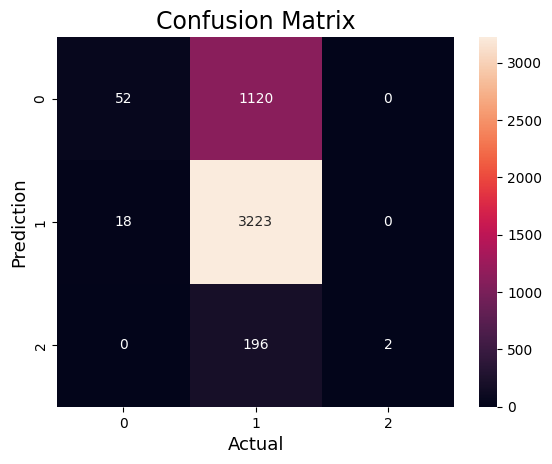

In [ ]:

#Import the necessary libraries
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
 
y_pred = evaluate(rfc, val, write_csv = False)
cm = confusion_matrix(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred)

 
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

### LGBM

In [ ]:
from lightgbm import LGBMClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


lgbm = LGBMClassifier(class_weight = 'balanced')
# lgbm.fit(train, train_df_orig.iloc[train_ind, :]['rating_label'])

import csv

def evaluate(classifier, test_df = test_df, label_encoder = None, write_csv = True):
  y_pred = classifier.predict(test_df)
  if label_encoder:
    y_pred = classifier.predict(test_df)
    y_pred = label_encoder.inverse_transform(y_pred)
  def info(y_pred):
    print(np.unique(y_pred))
    print(pd.DataFrame(y_pred).value_counts())

  if write_csv: 
    # write in the csv file
    with open('output.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'rating_label'])
        for i, rating in enumerate(y_pred):
            writer.writerow([i+1, rating])

  info(y_pred)
  return y_pred
  

# evaluate(rfc)

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[3. 4. 5.]
4.0    2601
3.0    1645
5.0     365
dtype: int64


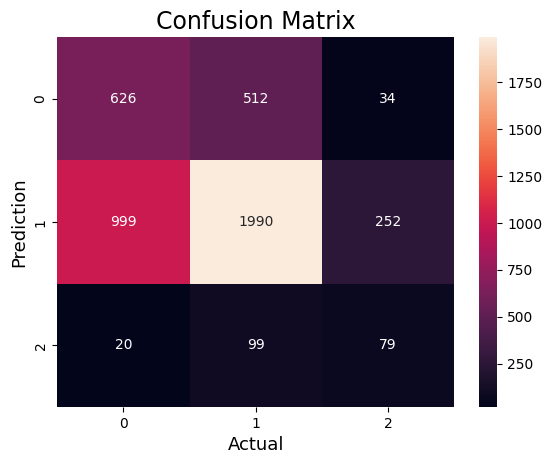

In [ ]:
# joblib.dump( lgbm, "lgbm_class_weight.joblib",)
lgbm = joblib.load("lgbm_class_weight.joblib")

y_pred = evaluate(lgbm, val, write_csv = False)
cm = confusion_matrix(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred)

 
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [ ]:
print(classification_report(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred))


              precision    recall  f1-score   support

         3.0       0.38      0.53      0.44      1172
         4.0       0.77      0.61      0.68      3241
         5.0       0.22      0.40      0.28       198

    accuracy                           0.58      4611
   macro avg       0.45      0.52      0.47      4611
weighted avg       0.64      0.58      0.60      4611



/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[3. 4. 5.]
4.0    4282
3.0     313
5.0      16
dtype: int64


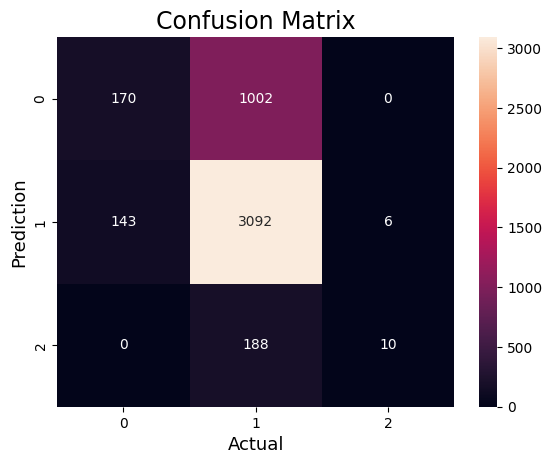

In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier()
# lgbm.fit(train, train_df_orig.iloc[train_ind, :]['rating_label'])


# joblib.dump( lgbm, "lgbm_normal.joblib",)
lgbm = joblib.load("lgbm_normal.joblib")

y_pred = evaluate(lgbm, val, write_csv = False)
cm = confusion_matrix(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred)

 
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred))

              precision    recall  f1-score   support

         3.0       0.54      0.15      0.23      1172
         4.0       0.72      0.95      0.82      3241
         5.0       0.62      0.05      0.09       198

    accuracy                           0.71      4611
   macro avg       0.63      0.38      0.38      4611
weighted avg       0.67      0.71      0.64      4611



In [ ]:
print(train.shape, train_df_orig.iloc[train_ind, :]['rating_label'].shape)

(18452, 117314) (18452,)


In [ ]:
desired_freq= {3.0: 9750, 4.0: 13000, 5.0: 9750}
from imblearn.over_sampling import SMOTE


# Create an instance of SMOTE
sm = SMOTE(sampling_strategy = desired_freq, random_state=42)

# Fit the SMOTE object with X and y
X_res, y_res = sm.fit_resample(train, train_df_orig.iloc[train_ind, :]['rating_label'])

/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (13000) in class 4.0 will be larger than the number of samples in the majority class (class #4.0 -> 12967)
  warnings.warn(


In [ ]:
print(X_res.shape, y_res.shape)
print(type(X_res), type(y_res))
import scipy.sparse as sp

# assume you have a sparse CSR matrix named 'sparse_matrix'
sp.save_npz('X_res.npz', X_res)

# assume you have a Pandas series named 'pandas_series'
y_res.to_csv('y_res.csv', index=False)

(32500, 117314) (32500,)
<class 'scipy.sparse._csr.csr_matrix'> <class 'pandas.core.series.Series'>


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[3. 4. 5.]
4.0    4093
3.0     428
5.0      90
dtype: int64


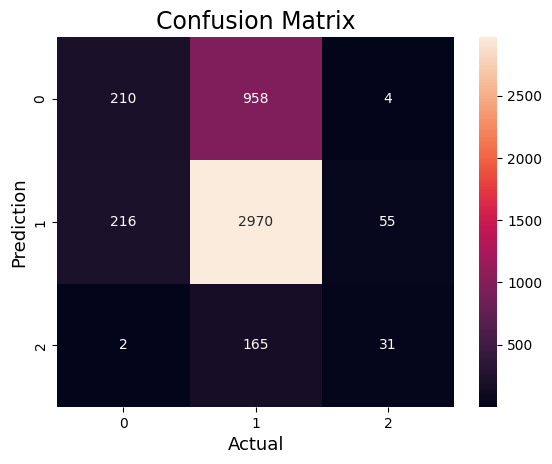

In [ ]:
lgbm = LGBMClassifier()
lgbm.fit(X_res, y_res)


joblib.dump( lgbm, "lgbm_oversampling.joblib",)
lgbm = joblib.load("lgbm_oversampling.joblib")

y_pred = evaluate(lgbm, val, write_csv = False)
cm = confusion_matrix(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred)

 
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [ ]:
print(classification_report(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred))

              precision    recall  f1-score   support

         3.0       0.49      0.18      0.26      1172
         4.0       0.73      0.92      0.81      3241
         5.0       0.34      0.16      0.22       198

    accuracy                           0.70      4611
   macro avg       0.52      0.42      0.43      4611
weighted avg       0.65      0.70      0.65      4611



In [ ]:
evaluate(lgbm, write_csv = False)

ValueError: ignored

### XGBoost Classifier

In [ ]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder


def experiment_xgboost(method, numerical, dimension_reduce, training = True):


  if training:
    rating = train_df_orig['rating_label']
    y_encoded = le.fit_transform(rating)
    classifier.fit(train_df, y_encoded)
    joblib.dump(classifier, f"./book_text_features_{method}/xg_method_{method}_numerical_{numerical}_reduce_{dimension_reduce}.pkl")
  else:
    classifier = joblib.load(f"./book_text_features_{method}/xg_method_{method}_numerical_{numerical}_reduce_{dimension_reduce}.pkl")

  return classifier, le

xgb, le = experiment_xgboost(method = 'tfidf', numerical = True, dimension_reduce = False, training = True)

In [ ]:
evaluate(xgb, le)

[3. 4. 5.]
4.0    5463
3.0     283
5.0      20
dtype: int64


In [ ]:
# save the trained model to disk
joblib.dump(xgb_clf, 'xgb_model.pkl')
# load the saved model from disk
loaded_model = joblib.load('xgb_model.pkl')

In [ ]:
# DocVec
train_df = pd.concat([train_desc, train_name, train_author], axis = 1)
test_df = pd.concat([test_desc, test_name, test_author], axis = 1)

print(train_df.shape, y_encoded.shape)
print(test_df.shape)

train_df.columns = list(range(220))
test_df.columns = list(range(220))

xgb_clf.fit(train_df, y_encoded)

# Prediction
y_pred = xgb_clf.predict(test_df)
y_pred = le.inverse_transform(y_pred)
print(y_pred)

# save the trained model to disk
joblib.dump(xgb_clf, 'xgb_model_doc.pkl')
# load the saved model from disk
loaded_model = joblib.load('xgb_model_doc.pkl')

(23063, 220) (23063,)
(5766, 220)
[4. 4. 4. ... 4. 4. 4.]


## DocVec

In [ ]:
df = pd.read_csv("book_rating_train.csv")
testdf = pd.read_csv("book_rating_test.csv")
testdf

,Name,Authors,PublishYear,PublishMonth,PublishDay,Publisher,Language,pagesNumber,Description
0,Near Occasions of Grace,Richard Rohr,1993,1,1,Orbis Books,NaN,118,Distilling the insights of more than 20 years ...
1,The Perfect Spot,Robert J. Blake,1997,3,17,Puffin,NaN,32,A surprising turn on a wilderness walk leads t...
2,Study Guide for Campbell Reece Biology,Martha R. Taylor,2005,1,1,Benjamin Cummings,eng,544,This printed learning aid provides a concept m...
3,"To Rescue A Rogue (Company of Rogues, #12)",Jo Beverley,2006,9,5,Signet,eng,432,Lady Mara St. Bride has never backed down from...
4,Soul Picnic: The Music and Passion of Laura Nyro,Michele Kort,2002,5,3,Thomas Dunne Books,NaN,352,<i>Soul Picnic: The Music and Passion of Laura...
...,...,...,...,...,...,...,...,...,...
5761,"The Wicca Herbal: Recipes, Magick, and Abundance",Jamie Martinez Wood,2003,9,1,Ten Speed Press,NaN,274,This work details and demystifies 100 magical ...
5762,Shifter's Desire: Vampire Fangs & Venom,Myra Nour,2004,9,10,Ellora's Cave,NaN,224,Shifters' Desire - Vampire Fangs and Venom By ...
5763,El Metodo Silva de Control Mental,José Silva,1999,12,14,Editorial Diana,NaN,224,El método Silva de Control Mental es un sistem...
5764,Renaissance and Renascences in Western Art,Erwin Panofsky,1972,6,21,Westview Press,eng,242,<i>Renaissance and Renascences in Western Art<...


In [ ]:
train_name = pd.read_csv(r"./book_text_features_doc2vec/train_name_doc2vec100.csv", index_col = False, delimiter = ',', header=None)
train_desc = pd.read_csv(r"./book_text_features_doc2vec/train_desc_doc2vec100.csv", index_col = False, delimiter = ',', header=None)
train_author = pd.read_csv(r"./book_text_features_doc2vec/train_authors_doc2vec20.csv", index_col = False, delimiter = ',', header=None)


test_name = pd.read_csv(r"./book_text_features_doc2vec/test_name_doc2vec100.csv", index_col = False, delimiter = ',', header=None)
test_desc = pd.read_csv(r"./book_text_features_doc2vec/test_desc_doc2vec100.csv", index_col = False, delimiter = ',', header=None)
test_author = pd.read_csv(r"./book_text_features_doc2vec/test_authors_doc2vec20.csv", index_col = False, delimiter = ',', header=None)


In [ ]:
print(train_name.shape, train_desc.shape, train_author.shape)
print(test_name.shape, test_desc.shape, test_author.shape)

(23063, 100) (23063, 100) (23063, 20)
(5766, 100) (5766, 100) (5766, 20)


In [ ]:
train_df = pd.concat([train_desc, train_name, train_author], axis = 1)
test_df = pd.concat([test_desc, test_name, test_author], axis = 1)

# final_scaler = StandardScaler()
# train_df = final_scaler.fit_transform(train_df)
# test_df = final_scaler.transform(test_df)
print(train_df.shape, test_df.shape)
print(num_df.shape, num_df_test.shape)
train_df = np.concatenate((train_df, num_df), axis = 1)
test_df = np.concatenate((test_df, num_df_test), axis = 1)

print(train_df.shape, test_df.shape)

# rf_doc = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_doc.fit(train_df, df['rating_label'])
# joblib.dump(rf_doc, "./random_forest_doc.joblib")

(23063, 220) (5766, 220)
(23063, 2) (5766, 2)
(23063, 222) (5766, 222)


In [ ]:
rfc = RandomForestClassifier(random_state = 42, n_estimators = 100)
rfc.fit(train_df, train_df_orig['rating_label'])
joblib.dump(rfc, f"./full_dataset/rf_docvec.joblib")

['./full_dataset/rf_docvec.joblib']

# Evaluation printing

In [ ]:

def evaluate(classifier, test_df = test_df, label_encoder = None, write_csv = True):
  y_pred = classifier.predict(test_df)
  if label_encoder:
    y_pred = classifier.predict(final_scaler.transform(test_df))
    y_pred = label_encoder.inverse_transform(y_pred)
  def info(y_pred):
    print(np.unique(y_pred))
    print(pd.DataFrame(y_pred).value_counts())

  if write_csv: 
    # write in the csv file
    with open('output.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'rating_label'])
        for i, rating in enumerate(y_pred):
            writer.writerow([i+1, rating])

  info(y_pred)
  return y_pred


evaluate(rfc, test_df = test_df, write_csv = True)

[3. 4.]
4.0    5750
3.0      16
dtype: int64


array([4., 4., 4., ..., 4., 4., 4.])

In [ ]:
pd.DataFrame(y_pred).value_counts()

4.0    5371
3.0     389
5.0       6
dtype: int64

In [ ]:
df = pd.read_csv("book_rating_train.csv")
df['rating_label'].value_counts()

4.0    16208
3.0     5864
5.0      991
Name: rating_label, dtype: int64